In [1]:
import numpy as np
import pandas as pd
import os
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Data path is assumed to be 'data' under repo root
def csv_loader(filename, datapath = "./data", stats = True):
    print('Loading %s.' % filename)
    path = os.path.join(datapath, filename)
    try:
        with open(path, 'rb') as f:
              data = pd.read_csv(f)
    except Exception as e:
        print('Unable to load data ', path, ':', e)
    if stats:
        print("{:d} rows of data loaded.".format(len(data)))
    return data

In [3]:
def merge_feature(df_base, df_merge, primary_key = "SK_ID_CURR", rename = dict(), suffixes = ("", "")):
    df_merge = df_merge.rename(columns=rename)
    df_base = df_base.merge(df_merge, on = primary_key, how = "left", suffixes = suffixes)
    return df_base

## bureau.csv

In [4]:
df_bureau = csv_loader("bureau.csv")
df_bureau.head(3)

Loading bureau.csv.
1716428 rows of data loaded.


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN


In [5]:
df_bureau.describe(include = "all")

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1716428,1716428,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1716428,1.716428e+06,4.896370e+05
unique,NaN,NaN,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,NaN,NaN
top,NaN,NaN,Closed,currency 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Consumer credit,NaN,NaN
freq,NaN,NaN,1079273,1715020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1251615,NaN,NaN
mean,2.782149e+05,5.924434e+06,NaN,NaN,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,NaN,-5.937483e+02,1.571276e+04
std,1.029386e+05,5.322657e+05,NaN,NaN,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,NaN,7.207473e+02,3.258269e+05
min,1.000010e+05,5.000000e+06,NaN,NaN,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,NaN,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,NaN,NaN,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,NaN,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,NaN,NaN,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,NaN,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,NaN,NaN,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,NaN,-3.300000e+01,1.350000e+04


# application{train|test}.csv

In [6]:
df_train = csv_loader("application_train.csv")
df_test = csv_loader("application_test.csv")

Loading application_train.csv.
307511 rows of data loaded.
Loading application_test.csv.
48744 rows of data loaded.


In [7]:
df_train["train_test"] = "train"
df_test["train_test"] = "test"
# base feature table only inculde an ID is in train/test
df_feat = pd.concat([df_train[["SK_ID_CURR", "train_test"]], df_test[["SK_ID_CURR", "train_test"]]])
print(df_feat.head(1))
print(df_feat.tail(1))

   SK_ID_CURR train_test
0      100002      train
       SK_ID_CURR train_test
48743      456250       test


## Feature Engineering

### SK_ID_BUREAU

In [8]:
bureau_hist = df_bureau.groupby("SK_ID_CURR").count()[["SK_ID_BUREAU"]].reset_index() # base feature table only inculde count bureau
df_feat = merge_feature(df_feat, bureau_hist, rename = {"SK_ID_BUREAU" : "count_bureau"})
df_feat.head(3)

,SK_ID_CURR,train_test,count_bureau
0,100002,train,8.0
1,100003,train,4.0
2,100004,train,2.0


In [9]:
# ID with no bureau evaluation
df_feat[["count_bureau"]].isnull().sum(axis=0)
df_feat["no_bureau"] = df_feat[["count_bureau"]].isnull()
df_feat.head(1)

,SK_ID_CURR,train_test,count_bureau,no_bureau
0,100002,train,8.0,False


In [10]:
df_feat.groupby("train_test")[["no_bureau"]].describe()

no_bureau                      
               count unique    top    freq
train_test                                
test           48744      2  False   42320
train         307511      2  False  263491

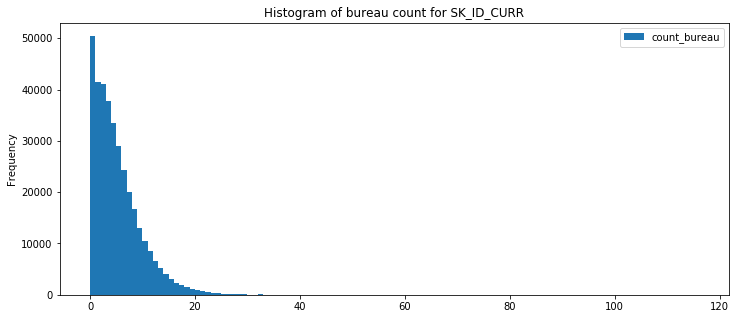

In [11]:
df_feat["count_bureau"] = df_feat["count_bureau"].fillna(0)
df_feat[["count_bureau"]].plot.hist(bins = int(max(df_feat["count_bureau"])), 
                      title = "Histogram of bureau count for SK_ID_CURR", figsize = (12, 5))
plt.show()

In [12]:
# Large count of Bureau (if one has bureau number more than 90% of ppl have)
sorted_bureau_hist = df_feat.sort_values("count_bureau").reset_index(drop = True)
sorted_bureau_hist.head(10)

,SK_ID_CURR,train_test,count_bureau,no_bureau
0,425815,train,0.0,True
1,187540,train,0.0,True
2,306845,test,0.0,True
3,349804,train,0.0,True
4,306876,test,0.0,True
5,306896,test,0.0,True
6,187520,train,0.0,True
7,187544,train,0.0,True
8,349807,train,0.0,True
9,445679,train,0.0,True


In [13]:
count_bureau_90 = sorted_bureau_hist.iloc[int(0.9 * len(sorted_bureau_hist))]["count_bureau"]
print("90% ppl has bureau less than {:f}".format(count_bureau_90))
sorted_bureau_hist["large_bureau_count"] = sorted_bureau_hist.count_bureau > count_bureau_90
sorted_bureau_hist.tail(3)

90% ppl has bureau less than 11.000000


,SK_ID_CURR,train_test,count_bureau,no_bureau,large_bureau_count
356252,318065,test,78.0,False,True
356253,169704,train,94.0,False,True
356254,120860,train,116.0,False,True


In [14]:
df_feat = merge_feature(df_feat, sorted_bureau_hist[["SK_ID_CURR", "large_bureau_count"]])
df_feat.head(1)

,SK_ID_CURR,train_test,count_bureau,no_bureau,large_bureau_count
0,100002,train,8.0,False,False


### DAYS_CREDIT

In [15]:
col = "DAYS_CREDIT"
creditdays_hist = df_bureau.groupby("SK_ID_CURR")[[col]].aggregate(["mean", "max", "min", "std"]).reset_index()
creditdays_hist.head()

SK_ID_CURR  DAYS_CREDIT                       
                     mean  max   min         std
0     100001  -735.000000  -49 -1572  489.942514
1     100002  -874.000000 -103 -1437  431.451040
2     100003 -1400.750000 -606 -2586  909.826128
3     100004  -867.000000 -408 -1326  649.124025
4     100005  -190.666667  -62  -373  162.297053

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:3108: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


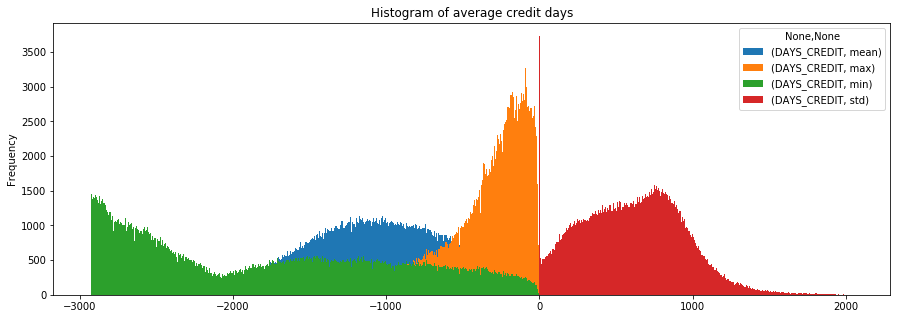

In [16]:
creditdays_hist.drop("SK_ID_CURR", axis = 1).plot.hist(
    bins = 1000, title = "Histogram of average credit days", figsize = (15, 5) )
plt.show()

In [17]:
df_feat = merge_feature(df_feat,creditdays_hist, rename = {"SK_ID_BUREAU" : "count_bureau"})

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:543: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:3108: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [18]:
df_feat.head()

,SK_ID_CURR,train_test,count_bureau,no_bureau,large_bureau_count,"(DAYS_CREDIT, mean)","(DAYS_CREDIT, max)","(DAYS_CREDIT, min)","(DAYS_CREDIT, std)"
0,100002,train,8.0,False,False,-874.00,-103.0,-1437.0,431.451040
1,100003,train,4.0,False,False,-1400.75,-606.0,-2586.0,909.826128
2,100004,train,2.0,False,False,-867.00,-408.0,-1326.0,649.124025
3,100006,train,0.0,True,False,NaN,NaN,NaN,NaN
4,100007,train,1.0,False,False,-1149.00,-1149.0,-1149.0,NaN


In [21]:
# Let the one with longest credict days take charge
longest_creadit = df_bureau.sort_values("DAYS_CREDIT", ascending = False).groupby("SK_ID_CURR").head(1)[["SK_ID_CURR", col]]
longest_creadit.head(2)

,SK_ID_CURR,DAYS_CREDIT
218508,405791,0
1021119,453003,0


In [23]:
df_feat = merge_feature(df_feat, longest_creadit, suffixes = ("", "_mainb"))
df_feat.head(3)

,SK_ID_CURR,train_test,count_bureau,no_bureau,large_bureau_count,"(DAYS_CREDIT, mean)","(DAYS_CREDIT, max)","(DAYS_CREDIT, min)","(DAYS_CREDIT, std)",DAYS_CREDIT,DAYS_CREDIT_mainb
0,100002,train,8.0,False,False,-874.00,-103.0,-1437.0,431.451040,-103.0,-103.0
1,100003,train,4.0,False,False,-1400.75,-606.0,-2586.0,909.826128,-606.0,-606.0
2,100004,train,2.0,False,False,-867.00,-408.0,-1326.0,649.124025,-408.0,-408.0


### CREDIT_DAY_OVERDUE

With 305811 customers, 301947 have 0-day overdue.


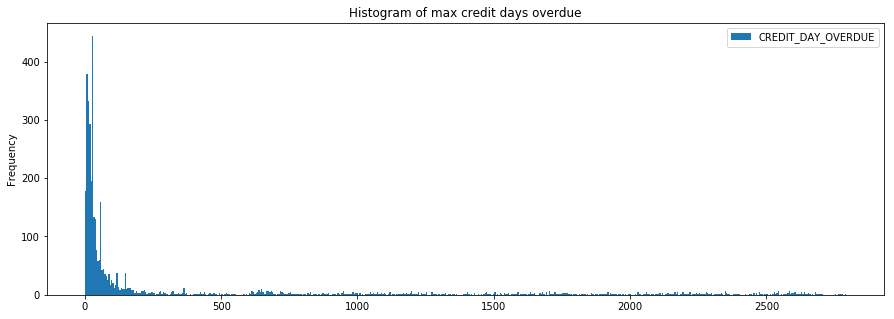

In [24]:
col = "CREDIT_DAY_OVERDUE"
creditdays_hist = df_bureau.sort_values(col, ascending = False).groupby("SK_ID_CURR").first()[[col]]
print("With {:d} customers, {:d} have 0-day overdue.".format(len(creditdays_hist), sum(creditdays_hist[col] == 0)))
creditdays_hist[creditdays_hist[col] != 0].plot.hist(
    bins = int(max(creditdays_hist[col])/5),
    title = "Histogram of max credit days overdue", figsize = (15, 5) )
plt.show()

In [25]:
creditdays_hist["has_overdue"] = creditdays_hist[col] != 0
df_feat = merge_feature(df_feat, creditdays_hist, rename = {col : "max_overdue"})
df_feat.head(3)

,SK_ID_CURR,train_test,count_bureau,no_bureau,large_bureau_count,"(DAYS_CREDIT, mean)","(DAYS_CREDIT, max)","(DAYS_CREDIT, min)","(DAYS_CREDIT, std)",DAYS_CREDIT,DAYS_CREDIT_mainb,max_overdue,has_overdue
0,100002,train,8.0,False,False,-874.00,-103.0,-1437.0,431.451040,-103.0,-103.0,0.0,False
1,100003,train,4.0,False,False,-1400.75,-606.0,-2586.0,909.826128,-606.0,-606.0,0.0,False
2,100004,train,2.0,False,False,-867.00,-408.0,-1326.0,649.124025,-408.0,-408.0,0.0,False


### CREDIT_TYPE

In [26]:
col = "CREDIT_TYPE"
types = df_bureau[col].unique()
print(types)

['Consumer credit' 'Credit card' 'Mortgage' 'Car loan' 'Microloan'
 'Loan for working capital replenishment' 'Loan for business development'
 'Real estate loan' 'Unknown type of loan' 'Another type of loan'
 'Cash loan (non-earmarked)' 'Loan for the purchase of equipment'
 'Mobile operator loan' 'Interbank credit'
 'Loan for purchase of shares (margin lending)']


In [27]:
def type_merge(x):
    if "loan" in x or "Loan" in x: return "Loan"
    else: return x

df_bureau["credit_type_coalease"] = df_bureau[col].apply(lambda x: type_merge(x))

In [28]:
credit_type_group = df_bureau.groupby(["SK_ID_CURR", "credit_type_coalease"]).count()[["SK_ID_BUREAU"]].reset_index()
credit_type = credit_type_group.pivot(index="SK_ID_CURR", columns="credit_type_coalease")
credit_type.head(2)

SK_ID_BUREAU                                    \
credit_type_coalease Consumer credit Credit card Interbank credit Loan   
SK_ID_CURR                                                               
100001                           7.0         NaN              NaN  NaN   
100002                           4.0         4.0              NaN  NaN   

                               
credit_type_coalease Mortgage  
SK_ID_CURR                     
100001                    NaN  
100002                    NaN

In [29]:
credit_type.columns = credit_type.columns.droplevel()
credit_type = credit_type.reset_index()
df_feat = merge_feature(df_feat, credit_type.fillna(0.0))
df_feat.head(3)

,SK_ID_CURR,train_test,count_bureau,no_bureau,large_bureau_count,"(DAYS_CREDIT, mean)","(DAYS_CREDIT, max)","(DAYS_CREDIT, min)","(DAYS_CREDIT, std)",DAYS_CREDIT,DAYS_CREDIT_mainb,max_overdue,has_overdue,Consumer credit,Credit card,Interbank credit,Loan,Mortgage
0,100002,train,8.0,False,False,-874.00,-103.0,-1437.0,431.451040,-103.0,-103.0,0.0,False,4.0,4.0,0.0,0.0,0.0
1,100003,train,4.0,False,False,-1400.75,-606.0,-2586.0,909.826128,-606.0,-606.0,0.0,False,2.0,2.0,0.0,0.0,0.0
2,100004,train,2.0,False,False,-867.00,-408.0,-1326.0,649.124025,-408.0,-408.0,0.0,False,2.0,0.0,0.0,0.0,0.0


In [30]:
df_feat.to_csv("./features/bureau_features.csv", index = False)